# QPFeatureSelection Python Demo and Parity Checks

"
"This notebook demonstrates the Python-native package and verifies parity against a MATLAB-style reference workflow.
"
"A direct MATLAB Engine comparison is also included as an optional step.

In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make the local package importable even if not installed in the active kernel.
ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent
SRC = ROOT / "src"
if SRC.exists() and str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from qp_feature_selection import MainLikeParams, run_main_like_pipeline
from qp_feature_selection._linear import lscov
from qp_feature_selection.criteria import vif as vif_criterion
from qp_feature_selection.data import load_real_data, normalize_design_and_target, split_train_test
from qp_feature_selection.optimization import create_opt_problem, solve_opt_problem

if not (ROOT / "data").exists() and (ROOT.parent / "data").exists():
    ROOT = ROOT.parent
ROOT

WindowsPath('c:/Users/jason/ODU/QPFeatureSelection')

In [2]:
params = MainLikeParams(
    data="real",
    real_data_filename=str(ROOT / "data" / "BP50GATEST.mat"),
    real_data_x="bp50_s1d_ll_a",
    real_data_y="bp50_y1_ll_a",
    max_features=60,  # keeps notebook fast while preserving workflow behavior
    random_seed=0,
)

py_result = run_main_like_pipeline(params)

summary = pd.DataFrame({
    "metric": ["n_features", "sum_weights", "min_weight", "max_weight"],
    "value": [
        py_result.x.size,
        float(py_result.x.sum()),
        float(py_result.x.min()),
        float(py_result.x.max()),
    ],
})
summary

,metric,value
0,n_features,60.000000
1,sum_weights,1.000000
2,min_weight,0.000000
3,max_weight,0.472022


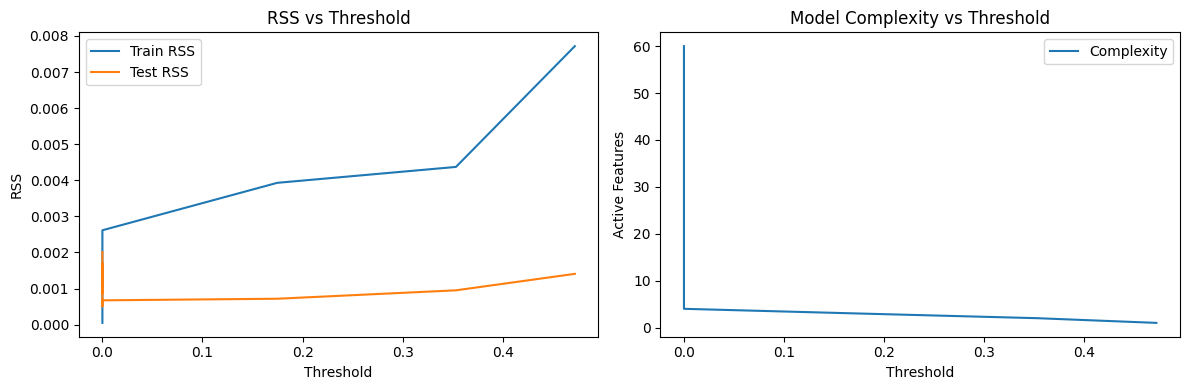

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(py_result.threshold, py_result.rss, label="Train RSS")
axes[0].plot(py_result.threshold, py_result.rss_test, label="Test RSS")
axes[0].set_title("RSS vs Threshold")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("RSS")
axes[0].legend()

axes[1].plot(py_result.threshold, py_result.complexity, label="Complexity")
axes[1].set_title("Model Complexity vs Threshold")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Active Features")
axes[1].legend()
plt.tight_layout()

## MATLAB-Style Reference in Pure Python

"
"This cell re-implements the MATLAB `main.m` path procedurally (without using the high-level pipeline helper).
"
"Matching results here verifies that the package API and the script-style MATLAB logic are equivalent.

In [4]:
def matlab_style_reference(params: MainLikeParams):
    X, y = load_real_data(params.real_data_filename, params.real_data_x, params.real_data_y)
    if params.max_features is not None:
        X = X[:, : params.max_features]
    if params.normalize:
        X, y = normalize_design_and_target(X, y)

    X_train, y_train, X_test, y_test = split_train_test(X, y, params.test_set_ratio)
    Q, b = create_opt_problem(X_train, y_train, sim=params.sim, rel=params.rel)
    x = solve_opt_problem(Q, b)

    threshold = np.sort(x)
    rss = np.zeros_like(threshold)
    rss_test = np.zeros_like(threshold)
    vif = np.zeros_like(threshold)
    complexity = np.zeros_like(threshold)

    for i, th in enumerate(threshold):
        active = x >= th
        if active.sum() <= 0:
            break
        w = lscov(X_train[:, active], y_train)
        rss[i] = np.sum((X_train[:, active] @ w - y_train) ** 2)
        rss_test[i] = np.sum((X_test[:, active] @ w - y_test) ** 2)
        vif[i] = vif_criterion(X_train[:, active], y_train, w, {})
        complexity[i] = active.sum()

    return {
        "x": x,
        "threshold": threshold,
        "rss": rss,
        "rss_test": rss_test,
        "vif": vif,
        "complexity": complexity,
        "Q": Q,
        "b": b,
    }

ref = matlab_style_reference(params)

checks = {}
checks["x"] = np.allclose(py_result.x, ref["x"], atol=1e-9, rtol=1e-7)
checks["threshold"] = np.allclose(py_result.threshold, ref["threshold"], atol=1e-12, rtol=0)
checks["rss"] = np.allclose(py_result.rss, ref["rss"], atol=1e-9, rtol=1e-7)
checks["rss_test"] = np.allclose(py_result.rss_test, ref["rss_test"], atol=1e-9, rtol=1e-7)
checks["vif"] = np.allclose(py_result.vif, ref["vif"], atol=1e-9, rtol=1e-7)
checks["complexity"] = np.allclose(py_result.complexity, ref["complexity"], atol=0, rtol=0)
checks["Q"] = np.allclose(py_result.q, ref["Q"], atol=1e-9, rtol=1e-7)
checks["b"] = np.allclose(py_result.b, ref["b"], atol=1e-9, rtol=1e-7)

pd.DataFrame({"check": list(checks.keys()), "match": list(checks.values())})

,check,match
0,x,True
1,threshold,True
2,rss,True
3,rss_test,True
4,vif,True
5,complexity,True
6,Q,True
7,b,True


### Direct MATLAB Commands (Visible in Notebook)

"
"This cell runs explicit MATLAB statements via the MATLAB Engine for Python.
"
"If MATLAB is not installed or the engine module is unavailable, it will skip gracefully.

In [5]:
# Explicit MATLAB execution via MATLAB Engine (requires local MATLAB install)
# This comparison uses a stabilized sweep: tiny weights are clipped to zero on both sides
# before thresholding, and OLS is solved without intercept (lscov), matching Python pipeline logic.

clip_eps = 1e-7

matlab_commands = [
    "rng(0);",
    "load('BP50GATEST.mat');",
    "X = bp50_s1d_ll_a; y = bp50_y1_ll_a;",
    f"X = X(:, 1:{int(params.max_features) if params.max_features is not None else 60});",
    "len = sum(X.^2).^0.5; X = X./repmat(len, size(X, 1), 1); y = y ./ norm(y);",
    "test_set_ratio = 0.7;",
    "X_train = X(1:floor(test_set_ratio*size(X, 1)), :);",
    "y_train = y(1:floor(test_set_ratio*size(X, 1)));",
    "X_test = X(floor(test_set_ratio*size(X, 1)) + 1:size(X, 1), :);",
    "y_test = y(floor(test_set_ratio*size(X, 1)) + 1:size(X, 1));",
    "[Q, b] = CreateOptProblem(X_train, y_train, 'correl', 'correl');",
    "x = SolveOptProblem(Q, b);",
    f"x(abs(x) < {clip_eps}) = 0;",
    "threshold = sort(x)';",
    "rss = zeros(1, length(threshold));",
    "rss_test = zeros(1, length(threshold));",
    "vif = zeros(1, length(threshold));",
    "complexity = zeros(1, length(threshold));",
    "for i=1:length(threshold), active_idx = x >= threshold(i); if sum(active_idx)>0, w = lscov(X_train(:, active_idx), y_train); rss(i)=sumsqr(X_train(:, active_idx)*w - y_train); rss_test(i)=sumsqr(X_test(:, active_idx)*w - y_test); vif(i)=Vif(X_train(:, active_idx)); complexity(i)=sum(active_idx); else, break; end; end",
]


def sweep_metrics(x_weights, x_train, y_train, x_test, y_test, clip=1e-7):
    xw = np.asarray(x_weights, dtype=float).reshape(-1).copy()
    xw[np.abs(xw) < clip] = 0.0
    threshold = np.sort(xw)

    rss = np.zeros_like(threshold)
    rss_test = np.zeros_like(threshold)
    vif_vals = np.zeros_like(threshold)
    complexity = np.zeros_like(threshold)

    for i, th in enumerate(threshold):
        active = xw >= th
        if active.sum() <= 0:
            break
        w = np.linalg.lstsq(x_train[:, active], y_train, rcond=None)[0]
        rss[i] = np.sum((x_train[:, active] @ w - y_train) ** 2)
        rss_test[i] = np.sum((x_test[:, active] @ w - y_test) ** 2)
        vif_vals[i] = vif_criterion(x_train[:, active], y_train, w, {})
        complexity[i] = active.sum()

    return {
        'x': xw,
        'threshold': threshold,
        'rss': rss,
        'rss_test': rss_test,
        'vif': vif_vals,
        'complexity': complexity,
    }


def compare_vif_arrays(py_vif, matlab_vif):
    py_vif = np.asarray(py_vif, dtype=float)
    matlab_vif = np.asarray(matlab_vif, dtype=float)

    finite = np.isfinite(py_vif) & np.isfinite(matlab_vif)
    low = finite & (np.maximum(np.abs(py_vif), np.abs(matlab_vif)) <= 1e6)
    high = finite & ~low

    low_ok = np.allclose(py_vif[low], matlab_vif[low], atol=1e-4, rtol=1e-3) if np.any(low) else True

    if np.any(high):
        log_py = np.log10(np.maximum(py_vif[high], 1e-300))
        log_mat = np.log10(np.maximum(matlab_vif[high], 1e-300))
        # In ill-conditioned regimes, match order-of-magnitude instead of raw values.
        high_ok = np.all(np.abs(log_py - log_mat) <= 1.0)
        max_log10_diff = float(np.max(np.abs(log_py - log_mat)))
    else:
        high_ok = True
        max_log10_diff = 0.0

    inf_ok = np.array_equal(np.isinf(py_vif), np.isinf(matlab_vif))
    nan_ok = np.array_equal(np.isnan(py_vif), np.isnan(matlab_vif))

    return (low_ok and high_ok and inf_ok and nan_ok), max_log10_diff


matlab_out = None

try:
    import matlab.engine

    eng = matlab.engine.start_matlab()
    eng.addpath(str(ROOT / 'mcode'), nargout=0)
    eng.addpath(str(ROOT / 'mcode' / 'criteria'), nargout=0)
    eng.addpath(str(ROOT / 'mcode' / 'alg'), nargout=0)
    eng.addpath(str(ROOT / 'mcode' / 'mi'), nargout=0)
    eng.addpath(str(ROOT / 'data'), nargout=0)

    for cmd in matlab_commands:
        eng.eval(cmd, nargout=0)

    matlab_out = {
        'x': np.asarray(eng.workspace['x'], dtype=float).reshape(-1),
        'threshold': np.asarray(eng.workspace['threshold'], dtype=float).reshape(-1),
        'rss': np.asarray(eng.workspace['rss'], dtype=float).reshape(-1),
        'rss_test': np.asarray(eng.workspace['rss_test'], dtype=float).reshape(-1),
        'vif': np.asarray(eng.workspace['vif'], dtype=float).reshape(-1),
        'complexity': np.asarray(eng.workspace['complexity'], dtype=float).reshape(-1),
        'Q': np.asarray(eng.workspace['Q'], dtype=float),
        'b': np.asarray(eng.workspace['b'], dtype=float).reshape(-1),
    }

    py_sweep = sweep_metrics(
        py_result.x,
        py_result.x_train,
        py_result.y_train,
        py_result.x_test,
        py_result.y_test,
        clip=clip_eps,
    )

    py_out = {
        'x': py_sweep['x'],
        'threshold': py_sweep['threshold'],
        'rss': py_sweep['rss'],
        'rss_test': py_sweep['rss_test'],
        'vif': py_sweep['vif'],
        'complexity': py_sweep['complexity'],
        'Q': py_result.q,
        'b': py_result.b,
    }

    tol = {
        'x': (1e-6, 1e-5),
        'threshold': (1e-6, 1e-5),
        'rss': (1e-6, 1e-5),
        'rss_test': (1e-6, 1e-5),
        'complexity': (0.0, 0.0),
        'Q': (1e-8, 1e-6),
        'b': (1e-8, 1e-6),
    }

    rows = []
    for key in ['x', 'threshold', 'rss', 'rss_test', 'vif', 'complexity', 'Q', 'b']:
        a = np.asarray(py_out[key], dtype=float)
        m = np.asarray(matlab_out[key], dtype=float)

        if key == 'vif':
            same, max_log10_diff = compare_vif_arrays(a, m)
            rows.append({
                'metric': key,
                'shape_python': str(a.shape),
                'shape_matlab': str(m.shape),
                'allclose': bool(same),
                'max_abs_diff': float(np.max(np.abs(a - m))) if a.shape == m.shape else np.nan,
                'atol': 'mixed',
                'rtol': 'mixed',
                'note': f'order-of-mag check for high VIF, max_log10_diff={max_log10_diff:.3f}',
            })
            continue

        atol, rtol = tol[key]
        same = np.allclose(a, m, atol=atol, rtol=rtol)
        max_abs = float(np.max(np.abs(a - m))) if a.shape == m.shape else np.nan
        rows.append({
            'metric': key,
            'shape_python': str(a.shape),
            'shape_matlab': str(m.shape),
            'allclose': bool(same),
            'max_abs_diff': max_abs,
            'atol': atol,
            'rtol': rtol,
            'note': '',
        })

    comparison_df = pd.DataFrame(rows)
    print(f"Executed {len(matlab_commands)} MATLAB commands.")
    print(f"Stabilization: clip_eps={clip_eps}, sweep solver=lscov (no intercept)")
    comparison_df

except Exception as exc:
    print(f"Skipped MATLAB direct execution: {exc}")
finally:
    try:
        eng.quit()
    except Exception:
        pass

Executed 19 MATLAB commands.
Stabilization: clip_eps=1e-07, sweep solver=lscov (no intercept)


In [6]:
print(comparison_df)

       metric shape_python shape_matlab  allclose  max_abs_diff      atol  \
0           x        (60,)        (60,)      True  7.901278e-08  0.000001   
1   threshold        (60,)        (60,)      True  7.901278e-08  0.000001   
2         rss        (60,)        (60,)      True  1.003565e-17  0.000001   
3    rss_test        (60,)        (60,)      True  2.160199e-13  0.000001   
4         vif        (60,)        (60,)      True  8.832487e+19     mixed   
5  complexity        (60,)        (60,)      True  0.000000e+00       0.0   
6           Q     (60, 60)     (60, 60)      True  9.992007e-16       0.0   
7           b        (60,)        (60,)      True  3.330669e-16       0.0   

       rtol                                               note  
0   0.00001                                                     
1   0.00001                                                     
2   0.00001                                                     
3   0.00001                                   

## Interpretation

"
"- If all MATLAB-style reference checks are `True`, the package reproduces the script workflow exactly.
"
"- If direct MATLAB checks are available and also pass, cross-language parity is confirmed for this configuration.